In [1]:
import os
import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [2]:
BASE_DIR = "dataset/"
names = ["grontol", "lanting", "lumpia", "putu ayu", "serabi solo", "wajik"]

tf.random.set_seed(1)

In [3]:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [4]:
orig_folders = ["grontol/", "lanting/", "lumpia/", "putu ayu/", "serabi solo/", "wajik/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    numer_of_images = len([name for name in files])
    n_train = int((numer_of_images * 0.7) + 0.5)
    n_valid = int((numer_of_images * 0.15) + 0.5)
    n_test = numer_of_images - n_train - n_valid
    print(numer_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

300 210 45 45
300 210 45 45
300 210 45 45
300 210 45 45
300 210 45 45
300 210 45 45


In [3]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                        rotation_range=20,
                                                        horizontal_flip=True,
                                                        vertical_flip=True,
                                                        zoom_range=0.2,
                                                        shear_range=0.2)
valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batches = train_gen.flow_from_directory(
    'dataset/train/',
    target_size=(224,224),
    class_mode='sparse',
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
    classes=names
)

val_batches = valid_gen.flow_from_directory(
    'dataset/val/',
    target_size=(224,224),
    class_mode='sparse',
    batch_size=32,
    shuffle=False,
    color_mode='rgb',
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'dataset/test/',
    target_size=(224,224),
    class_mode='sparse',
    batch_size=32,
    shuffle=False,
    color_mode='rgb',
    classes=names
)

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [4]:
class JavaFoodClassification_Model:
    def __init__(self):
        self.model = tf.keras.models.Sequential([
                  tf.keras.layers.Conv2D(32, (2,2), padding='same', activation='relu', input_shape=(224,224,3)),
                  tf.keras.layers.MaxPooling2D(),
                  tf.keras.layers.Conv2D(16, (2,2), padding='same', activation='relu'),
                  tf.keras.layers.MaxPooling2D(),
                  
                  tf.keras.layers.Flatten(),
                  tf.keras.layers.Dense(1024, activation='relu'),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.Dense(1024, activation='relu'),
                  tf.keras.layers.Dropout(0.4),
                  tf.keras.layers.Dense(512, activation='relu'),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.Dense(256, activation='relu'),
                  tf.keras.layers.Dropout(0.4),
                  tf.keras.layers.Dense(128, activation='relu'),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.Dense(6, activation='softmax'),
              ])
    def summary(self):
        return self.model.summary()
    def compile(self):
        return self.model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])
    def fit(self):
        # Training
        epochs = 50

        # Callbacks
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=1
        )  

        history = self.model.fit(train_batches, validation_data=val_batches,callbacks=[early_stopping], epochs=epochs, verbose=1)
        return history
    def predict_single_img(self, src_img, img_width, img_height):
        # dimensions of our images
        img_width, img_height = img_width, img_height

        img = image.load_img(src_img, target_size=(img_width, img_height))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        images = np.vstack([x])
        classes = self.model.predict_classes(images, batch_size=10)

        label = names[classes[0]]

        plt.title(label)
        plt.imshow(img)
    def predict_multiple_img(self, test_img):
        i = 1
        plt.figure(figsize=(15,20))
        for images, labels in iter(test_img):
            id = np.random.randint(32)
            image = images[id]
            label = names[int(labels[id])]
            proba = self.model.predict(image[np.newaxis,...])
            pred = names[np.argmax(proba)]
            max_proba = float(max(proba[0]))

            font = {"color":"r"} if label != pred else {"color":"g"}
            plt.subplot(5,3,i)

            plt.imshow(image)
            plt.title(f"Label : {label}, Prediction : {pred}", fontdict=font)
            plt.axis('off')

            i+=1
            if i>=16:
                break

        plt.tight_layout()
        plt.show()

In [5]:
model = JavaFoodClassification_Model()

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      2064      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              51381248  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

In [7]:
model.compile()

In [8]:
history = model.fit()

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 40 steps, validate for 9 steps
Epoch 1/50
40/40 [==============================] - 81s 2s/step - loss: 1.8720 - accuracy: 0.1659 - val_loss: 1.7911 - val_accuracy: 0.1667
Epoch 2/50
40/40 [==============================] - 74s 2s/step - loss: 1.8082 - accuracy: 0.1865 - val_loss: 1.7843 - val_accuracy: 0.2185
Epoch 3/50
40/40 [==============================] - 76s 2s/step - loss: 1.7885 - accuracy: 0.1849 - val_loss: 1.7693 - val_accuracy: 0.2741
Epoch 4/50
40/40 [==============================] - 82s 2s/step - loss: 1.7705 - accuracy: 0.2262 - val_loss: 1.7398 - val_accuracy: 0.3074
Epoch 5/50
40/40 [==============================] - 74s 2s/step - loss: 1.7218 - accuracy: 0.2643 - val_loss: 1.6691 - val_accuracy: 0.3630
Epoch 6/50
40/40 [==============================] - 79s 2s/step - loss: 1.6722 - accuracy: 0.2802 - val_loss: 1.5954 - val_accuracy: 0.3185
Epoch 7/50
40/40 [==============================] - 83s 2s/step - los

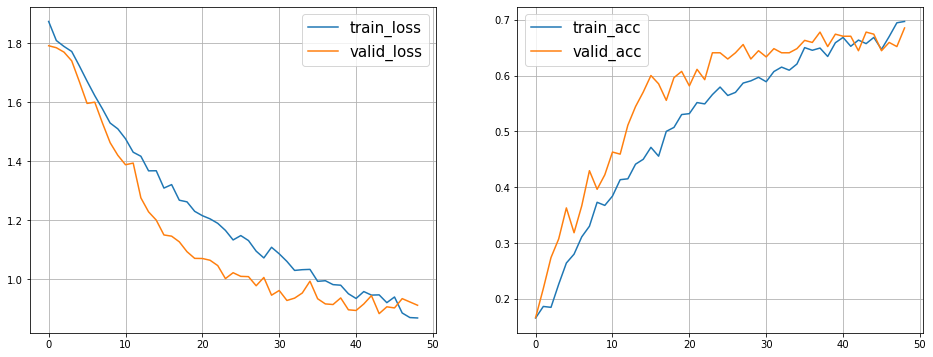

In [9]:
import matplotlib.pyplot as plt
# Plot loss and acc
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='valid_loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='valid_acc')
plt.grid()
plt.legend(fontsize=15)

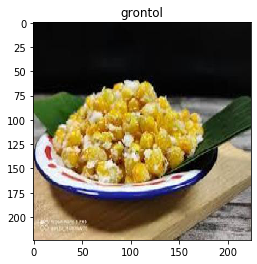

In [11]:
model.predict_single_img('dataset/test/grontol/grontol_61.jpg', 224, 224)

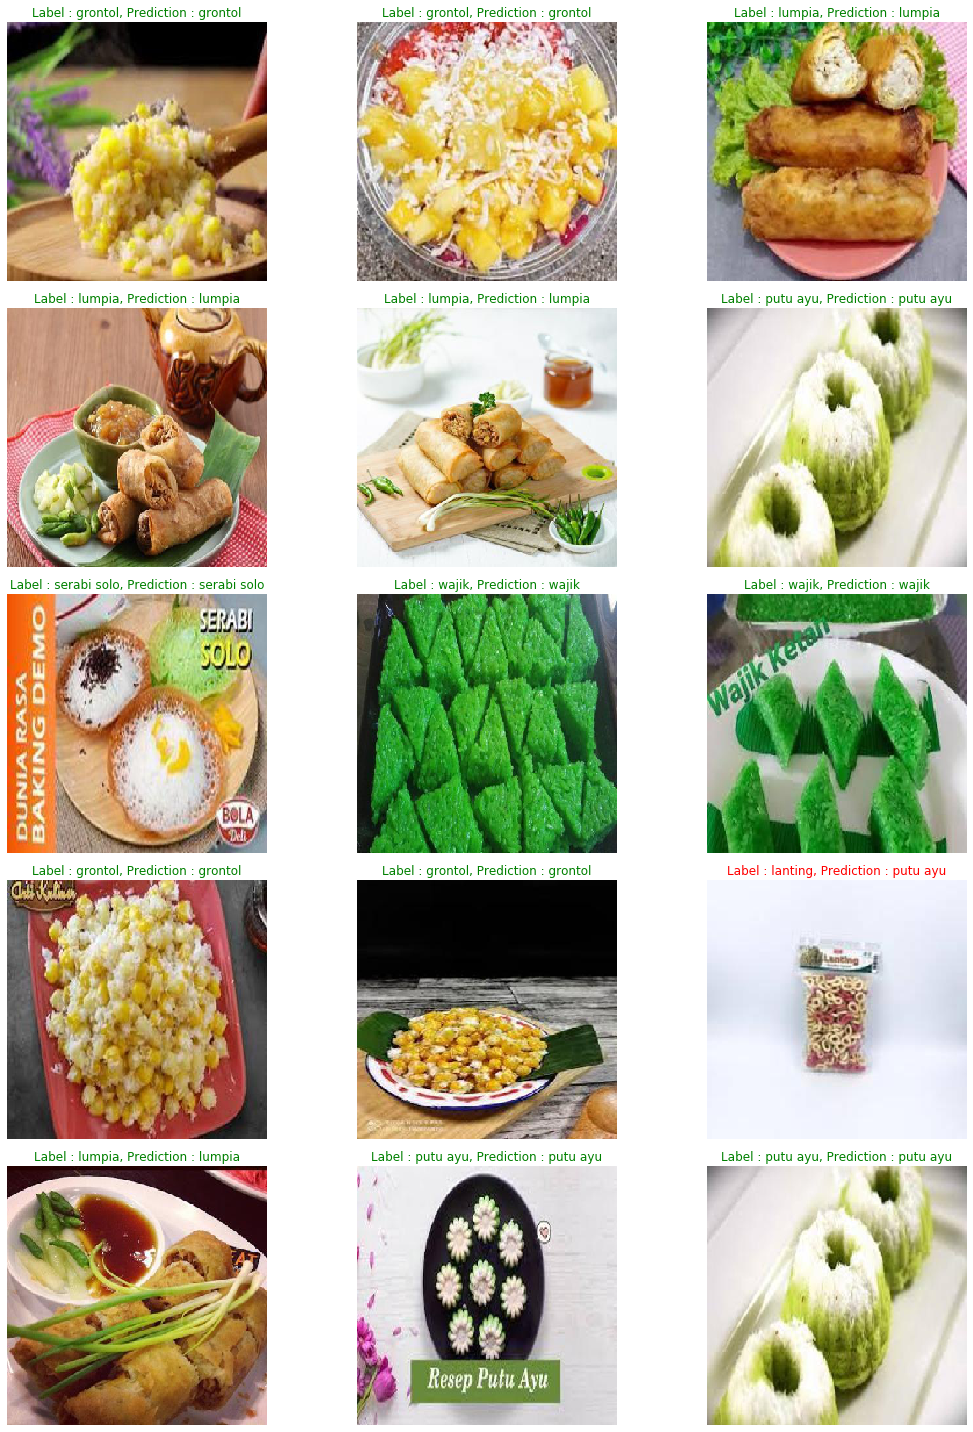

In [14]:
model.predict_multiple_img(test_batches)